# Which MMSI are Used by Multiple Vessels?

This is the fourth take at getting a good spoofing list

1) Eliminate all segments that have fewer than 100 points and are all terrestrial, and which are not clumped right next to the equator or prime meridian. This will get rid of many valid segments, but it will also eliminate most of the noise. (A beter analysis will later get rid of more noise). 

```
SELECT
  * from(
  SELECT
    mmsi,
    seg_id,
    first_timestamp,
    last_timestamp,
    LAG(last_timestamp,1) OVER (PARTITION BY mmsi ORDER BY first_timestamp) last_previous_segment,
    LEAD(first_timestamp,1) OVER (PARTITION BY mmsi ORDER BY first_timestamp) first_next_segment
  FROM
    [scratch_david_seg_analysis.2015_segments]
  WHERE
    (point_count >=100
      OR (point_count>10
        AND terrestrial_positions != point_count))
    AND (last_timestamp - first_timestamp)/3600000000 > 12 // more than 12 hours
    AND NOT ((min_lon >= 0 // these are almost definitely noise
        AND max_lon <= 0.109225)
      OR (min_lat >= 0
        AND max_lat <= 0.109225)) )
WHERE
  mmsi IN (
  SELECT
    mmsi
  FROM
    [scratch_bjorn.2015_combined_fishing])
```
Save to table: `[scratch_david_seg_analysis.good_fishing_segments_2015]`

2) Look at segments that overlap, and ignore the ones that should not be brocken up into different segments -- that is, look at the average distance between consecutive points, and determine if they are realistic segments. We have to eliminate these because it looks like the segmenter was dividing what should be continuous segments into different segments, which in turn made some vessels have overlap which clearly did not have overlap.

```
SELECT
  seg_id
FROM (
  SELECT
    a.mmsi mmsi,
    b.seg_id seg_id,
    b.first_timestamp overalp_start,
    IF(a.last_timestamp < b.last_timestamp, a.last_timestamp, b.last_timestamp) overlap_end,
    /*a.first_timestamp,
      b.first_timestamp,
      a.last_timestamp,
      b.last_timestamp,
      IF(a.last_timestamp < b.last_timestamp, a.last_timestamp - b.first_timestamp, b.last_timestamp - b.first_timestamp)/3600000000 spoofing_hours,*/
  FROM (
    SELECT
      *
    FROM
      [scratch_david_seg_analysis.good_fishing_segments_2015] a
    JOIN
      [scratch_david_seg_analysis.good_fishing_segments_2015] b
    ON
      a.mmsi = b.mmsi)
  WHERE
    a.first_timestamp < b.first_timestamp
    AND b.first_timestamp < a.last_timestamp),
  (
  SELECT
    a.mmsi mmsi,
    a.seg_id seg_id,
    b.first_timestamp overalp_start,
    IF(a.last_timestamp < b.last_timestamp, a.last_timestamp, b.last_timestamp) overlap_end,
    /*a.first_timestamp,
      b.first_timestamp,
      a.last_timestamp,
      b.last_timestamp,
      IF(a.last_timestamp < b.last_timestamp, a.last_timestamp - b.first_timestamp, b.last_timestamp - b.first_timestamp)/3600000000 spoofing_hours,*/
  FROM (
    SELECT
      *
    FROM
      [scratch_david_seg_analysis.good_fishing_segments_2015] a
    JOIN
      [scratch_david_seg_analysis.good_fishing_segments_2015] b
    ON
      a.mmsi = b.mmsi)
  WHERE
    a.first_timestamp < b.first_timestamp
    AND b.first_timestamp < a.last_timestamp)
GROUP BY
  seg_id
```

Save to `[scratch_david_seg_analysis.overlapping_segments_v2]`
This lists all the segements that are overlapping in time

```
SELECT
  mmsi,
  seg_id,
  next_seg_id,
  timestamp,
  if (gap_seconds = 0,
    gapmeters/(.000001),
    gapmeters/gap_seconds) speed,
  gapmeters,
  gap_seconds,
FROM (
SELECT
  mmsi,
  seg_id,
  next_seg_id,
  timestamp,
  lat,
  lon,
  next_lat,
  next_lon,
  (ACOS(COS(RADIANS(90-lat)) *COS(RADIANS(90-next_lat)) +SIN(RADIANS(90-lat)) *SIN(RADIANS(90-next_lat)) * COS(RADIANS(lon-next_lon)))*6371000) gapmeters,
  (next_timestamp - timestamp)/1000000 gap_seconds
FROM (
  SELECT
    mmsi,
    seg_id,
    LEAD(seg_id, 1) OVER (PARTITION BY mmsi ORDER BY timestamp) next_seg_id,
    timestamp,
    LEAD(timestamp, 1) OVER (PARTITION BY mmsi ORDER BY timestamp) next_timestamp,
    lat,
    lon,
    LEAD(lat, 1) OVER (PARTITION BY mmsi ORDER BY timestamp) next_lat,
    LEAD(lon, 1) OVER (PARTITION BY mmsi ORDER BY timestamp) next_lon,
  FROM (
    SELECT
      mmsi,
      seg_id,
      lat,
      lon,
      timestamp,
      type
    FROM (
      SELECT
        mmsi,
        seg_id,
        lat,
        lon,
        timestamp,
        type
      FROM
        TABLE_DATE_RANGE([pipeline_classify_fishing.], TIMESTAMP('2015-01-01'), TIMESTAMP('2015-12-31')))
    WHERE
      seg_id IN (
      SELECT
        seg_id
      FROM
        [scratch_david_seg_analysis.overlapping_segments_v2])
      AND type IN (1,2,3,18,19)
      AND lat IS NOT NULL
      AND lon IS NOT NULL) )
WHERE
  seg_id != next_seg_id)
```

Save to `[scratch_david_seg_analysis.overlapping_segments_v2_pointjumps]`
This cacluates how the vessel jumps back and forth between two segments, calculating the time and distance between two consecutive points that are in different segments.


```
SELECT
    mmsi,
    seg_id,
    next_seg_id,
    AVG(gap_seconds) avg_gap_seconds,
    SUM(gap_seconds) tot_gap_seconds,
    AVG(gapmeters) avg_gap_meters,
    SUM(gapmeters) tot_gap_meters,
    IF(SUM(gap_seconds)=0, if (avg_gap_meters < 10000, 10,100000), AVG(gapmeters)/AVG(gap_seconds)) avg_speed,
    COUNT(*) jumps
  FROM
    [scratch_david_seg_analysis.overlapping_segments_v2_pointjumps]
  WHERE
    speed IS NOT NULL
    AND gapmeters >=0
  GROUP BY
    mmsi,
    seg_id,
    next_seg_id
  ORDER BY
    avg_speed ASC
```

Save to [scratch_david_seg_analysis.overlapping_segments_v2_pointjumps_stats]


```
SELECT
  seg_id,
  next_seg_id,
  tot_gap_seconds,
  tot_gap_meters,
  tot_jumps,
  tot_gap_meters/tot_gap_seconds avg_speed
FROM (
  SELECT
    IF(a.seg_id > a.next_seg_id, a.seg_id, a.next_seg_id) seg_id,
    IF(a.seg_id > a.next_seg_id, a.next_seg_id, a.seg_id) next_seg_id,
    a.tot_gap_seconds + IF(b.tot_gap_seconds IS NULL, 0,b.tot_gap_seconds) tot_gap_seconds,
    a.tot_gap_meters + IF(b.tot_gap_meters IS NULL, 0,b.tot_gap_meters) tot_gap_meters,
    a.jumps + IF(b.jumps IS NULL, 0,b.jumps) tot_jumps,
  FROM (
    SELECT
      *
    FROM
      [scratch_david_seg_analysis.overlapping_segments_v2_pointjumps_stats] a
    LEFT JOIN
      [scratch_david_seg_analysis.overlapping_segments_v2_pointjumps_stats] b
    ON
      a.seg_id = b.next_seg_id
      AND a.next_seg_id = b.seg_id)
  GROUP BY
    seg_id,
    next_seg_id,
    tot_gap_seconds,
    tot_gap_meters,
    tot_jumps )
```

Save to `[scratch_david_seg_analysis.overlapping_segments_v2_pointjumps_stats_b]`

The results of these two queries are a list of pairs of segements and the average distance between points on them that are consecutive in time.

3) Sum the overlapping time by vessel, including only the segements above that are physically impossible (in this case where the aveage speed has to be >100 knots in order to jump between the two segments). This is done below.




In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib
from matplotlib import colors,colorbar
%matplotlib inline
import csv 
import math
import bq
import time
import cPickle 
from mpl_toolkits.basemap import Basemap

In [3]:
client = bq.Client.Get()
def Query(q):
    t0 = time.time()
    answer = client.ReadTableRows(client.Query(q)['configuration']['query']['destinationTable'])
    print 'Query time: ' + str(time.time() - t0) + ' seconds.'
    return answer

In [4]:
# This query looks at only 2015, and only fishing vessels

q = '''
SELECT
  a.mmsi mmsi,
  ROUND(a.spoofing_hours,1) spoofing_hours,
  ROUND(b.total_hours,1) total_hours,
  ROUND(100*a.spoofing_hours/b.total_hours,2) spoofing_percent,
  a.overlapping_segments overlapping_segments,
  b.num_segments num_segments
FROM (
  SELECT
    mmsi,
    SUM(spoofing_hours) spoofing_hours,
    COUNT(*) overlapping_segments
  FROM (
    SELECT
      *,
      CONCAT(seg_id, next_seg_id) segs
    FROM (
      SELECT
        a.mmsi mmsi,
        IF(a.seg_id > b.seg_id, a.seg_id, b.seg_id) seg_id,
        IF(a.seg_id > b.seg_id, b.seg_id, a.seg_id) next_seg_id,
        IF(a.last_timestamp < b.last_timestamp, a.last_timestamp - b.first_timestamp, b.last_timestamp - b.first_timestamp)/3600000000 spoofing_hours,
      FROM (
        SELECT
          *
        FROM
          [scratch_david_seg_analysis.good_fishing_segments_2015] a
        JOIN
          [scratch_david_seg_analysis.good_fishing_segments_2015] b
        ON
          a.mmsi = b.mmsi)
      WHERE
        a.first_timestamp < b.first_timestamp
        AND b.first_timestamp < a.last_timestamp)
    HAVING
      segs IN (
      SELECT
        CONCAT(seg_id, next_seg_id) segs
      FROM
        [scratch_david_seg_analysis.overlapping_segments_v2_pointjumps_stats_b]
      WHERE
        avg_speed > 100))
  GROUP BY
    mmsi
  ORDER BY
    spoofing_hours DESC ) a
JOIN (
  SELECT
    mmsi,
    SUM((last_timestamp - first_timestamp))/3600000000 total_hours,
    COUNT(*) num_segments
  FROM
    [scratch_david_seg_analysis.good_fishing_segments_2015]
  GROUP BY
    mmsi ) b
ON
  a.mmsi = b.mmsi
ORDER BY
  spoofing_hours DESC'''

overlaps = Query(q)

Waiting on bqjob_r34289ec091ad6f61_0000015473276fb6_1 ... (0s) Current status: DONE   
Query time: 2.05902695656 seconds.


In [5]:
print "mmsi spoofing_hours total_hours spoofing_Percent overlapping_segments"
for i in range(len(overlaps)):
    o = overlaps[i]
    print o[0],o[1],o[2],o[3]+"%", o[4]

mmsi spoofing_hours total_hours spoofing_Percent overlapping_segments
123456789 395706.1 85481.0 462.92% 8439
222222222 65731.9 35657.9 184.34% 1886
701007014 5481.0 14898.9 36.79% 85
354622000 5191.3 13274.7 39.11% 63
412331079 4431.5 12756.8 34.74% 47
440787000 3559.0 12322.9 28.88% 101
412333333 3134.4 10122.5 30.96% 73
412420405 2682.0 11301.9 23.73% 23
367061930 2613.2 14759.5 17.71% 104
412420502 2556.6 9962.9 25.66% 59
440773000 1945.4 10622.4 18.31% 104
412200146 1426.1 6681.3 21.34% 26
412400155 1391.1 7387.5 18.83% 13
412320023 1337.4 6246.6 21.41% 18
440100000 1129.0 9856.1 11.45% 13
416002477 1104.2 7310.7 15.1% 9
345050700 1085.1 9184.6 11.81% 49
273892110 1043.5 9635.9 10.83% 24
312854000 997.1 7691.0 12.96% 17
345140500 961.6 7295.4 13.18% 84
412466666 941.1 5140.8 18.31% 20
701006034 874.9 7703.8 11.36% 8
412447093 872.7 5098.4 17.12% 18
413222000 836.2 7300.3 11.45% 7
412420197 820.8 9600.9 8.55% 20
412678050 812.2 9539.9 8.51% 12
257222222 795.8 3728.5 21.34% 2
273828

In [6]:
print "total number of vessels with at least one overlap:", len(overlaps)

total number of vessels with at least one overlap: 480


In [15]:
for i in range(len(overlaps)):
    o = overlaps[i]
    if o[0] == '258154000':
        print o

# Let's map some of these



In [10]:
def map_mmsi(mmsi, title = ""):
    if title == "":
        title = 'Vessel '+str(mmsi)
    plt.rcParams["figure.figsize"] = [12,7]
    q = ''' select * from (select timestamp, lat, lon, speed, seg_id 
    FROM (TABLE_DATE_RANGE([pipeline_classify_fishing.], TIMESTAMP('2015-01-01'), TIMESTAMP('2015-12-31')))
    where mmsi = '''+str(mmsi) + '''
    and lat is not null and lon is not null 
    and lat <90 and lat>-90 and lon<180 and lon>-180)
    where seg_id in (select seg_id from [scratch_david_seg_analysis.good_fishing_segments_2015]
    where mmsi ='''+str(mmsi) + ''' )
    order by timestamp'''

    ves = Query(q)

    lats = np.array([float(v[1]) for v in ves])
    lons = np.array([float(v[2]) for v in ves])

    min_lat = min(lats)
    min_lon = min(lons)
    max_lat = max(lats)
    max_lon = max(lons)

    if max_lat>90: max_lat = 90
    if min_lat<-90: min_lat = -90

    m =\
    Basemap(llcrnrlon=min_lon,llcrnrlat=min_lat,urcrnrlon=max_lon,urcrnrlat=max_lat,projection='mill', resolution ='l')

    m.drawmapboundary()
    m.fillcontinents("#cccccc")
    x,y= m(lons,lats)
    color =  "#7879FA"   
    size = 2
    m.plot(x, y, lw=1, color = "#000000",alpha=.5)
    m.plot(x, y, marker = 'o', alpha=.5,lw=0, ms=5,markeredgecolor = 'none',color = "#FF0000")
    plt.title(title)   
    plt.savefig(str(mmsi)+".png",bbox_inches='tight',dpi=900,transparent=True,pad_inches=.1)
    plt.show()
    plt.clf()


Waiting on bqjob_r9c89b24725af8fe_00000154732c5381_2 ... (15s) Current status: DONE   
Query time: 19.4366979599 seconds.


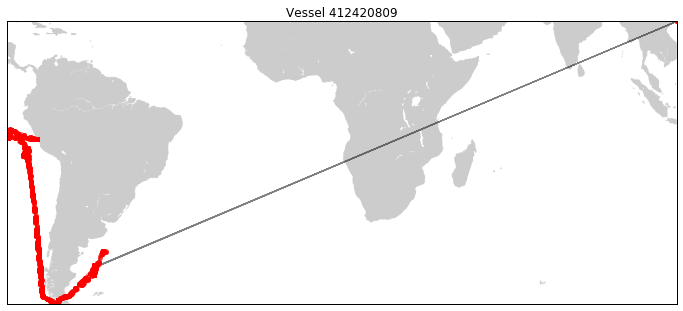

In [16]:
# 30 hours of spoofing
map_mmsi(412420809)

Waiting on bqjob_r2a677eed0fc9528c_00000154732ceacd_3 ... (23s) Current status: DONE   
Query time: 27.9730279446 seconds.


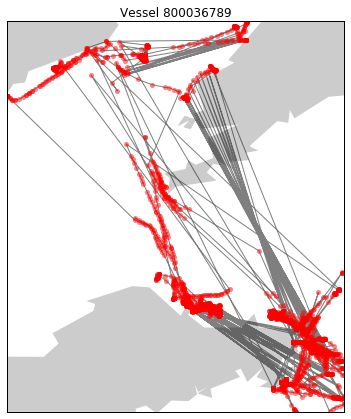

In [17]:
#  30 hours of spoofing
map_mmsi(800036789)

## Yes, spoofing

Waiting on bqjob_r18beff60457a2f19_00000154732e7a41_4 ... (23s) Current status: DONE   
Query time: 40.7500221729 seconds.


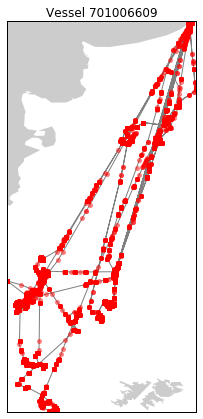

In [18]:
# 10 hours of spoofing
map_mmsi(701006609)

## Doesn't look like it from this, but on closer inspection, it is spoofing

```
SELECT
  *
FROM (
  SELECT
    timestamp,
    lat,
    lon,
    speed,
    seg_id
  FROM (TABLE_DATE_RANGE([pipeline_classify_fishing.], TIMESTAMP('2015-01-01'), TIMESTAMP('2015-12-31')))
  WHERE
    lat IS NOT NULL
    AND lon IS NOT NULL
    AND lat <90
    AND lat>-90
    AND lon<180
    AND lon>-180)
WHERE
  seg_id IN ('701006609-2015-03-30T00:14:58.000000Z',
    '701006609-2015-03-29T16:28:42.000000Z')
ORDER BY
  timestamp
```

Waiting on bqjob_r42a06a0fb1bb1df1_00000154732fca92_5 ... (15s) Current status: DONE   
Query time: 18.4555640221 seconds.


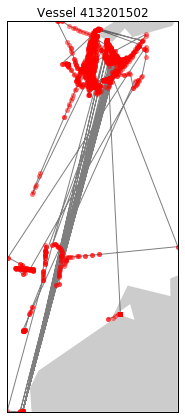

In [19]:
# 10 hours of spoofing
map_mmsi(413201502)

## probably, but hard to tell

Waiting on bqjob_r76872bcd10f11bd8_00000154733de974_6 ... (15s) Current status: DONE   
Query time: 23.1419098377 seconds.


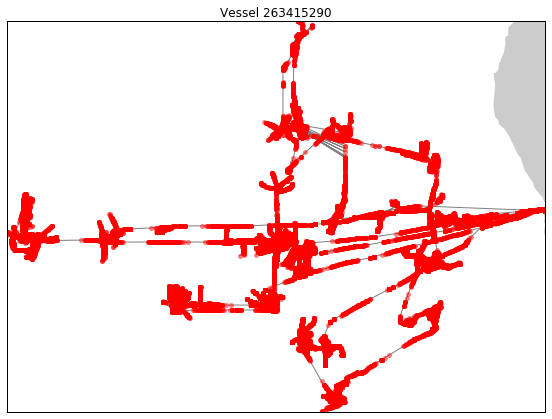

In [20]:
# 5 hours of spoofing
map_mmsi(263415290)

## Looks like it for just a few hours

mmsi spoofing_hours total_hours spoofing_Percent overlapping_segments
Waiting on bqjob_r732547abf90f918b_00000154733eddca_7 ... (14s) Current status: DONE   
Query time: 22.7877290249 seconds.


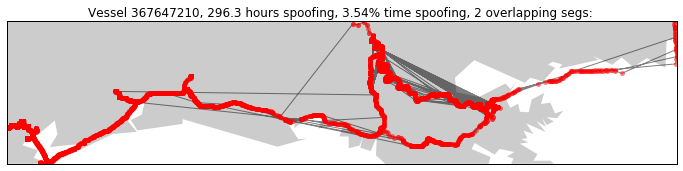

Waiting on bqjob_r790f4f72e0bb72b2_00000154733f839c_8 ... (23s) Current status: DONE   
Query time: 29.380439043 seconds.


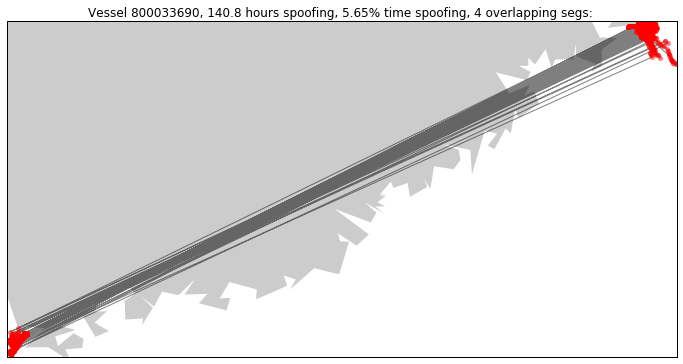

Waiting on bqjob_r6a96a2cbebf9bec1_000001547340420a_9 ... (23s) Current status: DONE   
Query time: 28.1823270321 seconds.


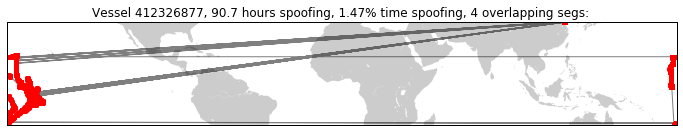

Waiting on bqjob_r3e97854668b69ddb_000001547340f09b_10 ... (23s) Current status: DONE   
Query time: 27.7723579407 seconds.


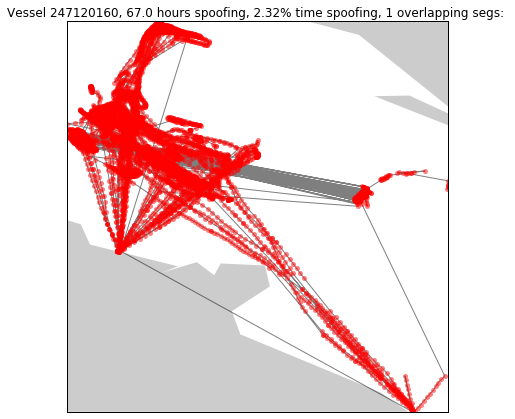

Waiting on bqjob_r390e7c4950728626_000001547341aab0_11 ... (15s) Current status: DONE   
Query time: 19.6311221123 seconds.


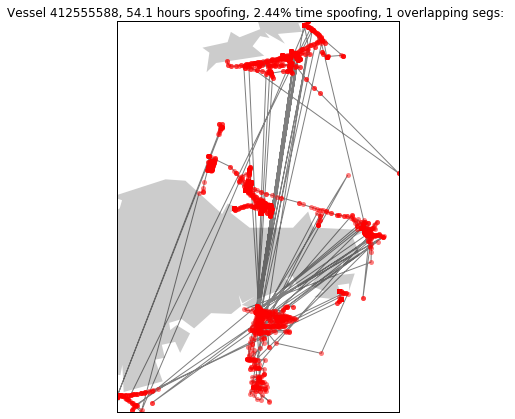

Waiting on bqjob_r523862ea97537b86_0000015473423f84_12 ... (15s) Current status: DONE   
Query time: 18.884816885 seconds.


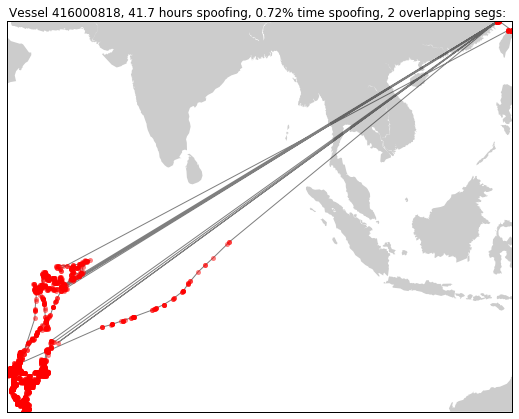

Waiting on bqjob_r1fab0e4796e78907_000001547342d28a_13 ... (14s) Current status: DONE   
Query time: 18.8462719917 seconds.


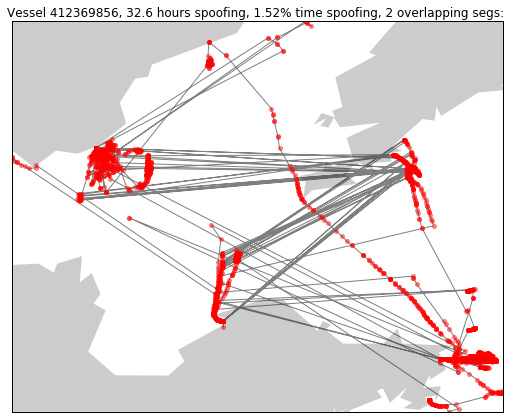

Waiting on bqjob_r29028fada7639318_0000015473436690_14 ... (14s) Current status: DONE   
Query time: 18.9064240456 seconds.


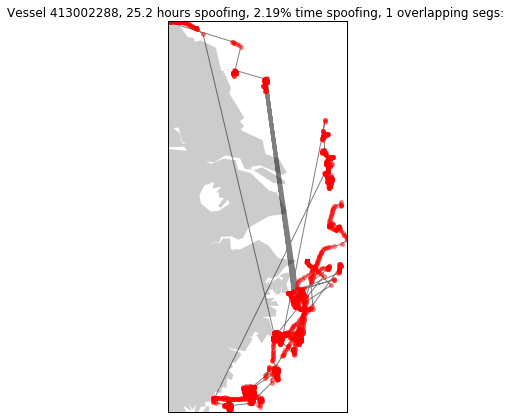

Waiting on bqjob_r1fd95e2b583b7e9c_000001547343f5b3_15 ... (23s) Current status: DONE   
Query time: 29.6137051582 seconds.


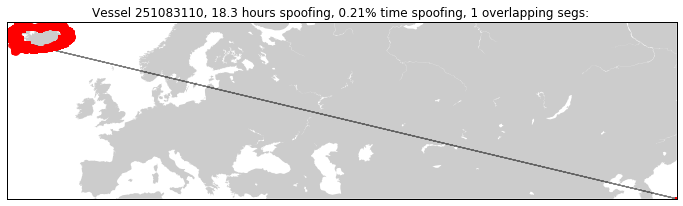

Waiting on bqjob_r53730d8636f1612d_000001547344b3b2_16 ... (15s) Current status: DONE   
Query time: 20.1901669502 seconds.


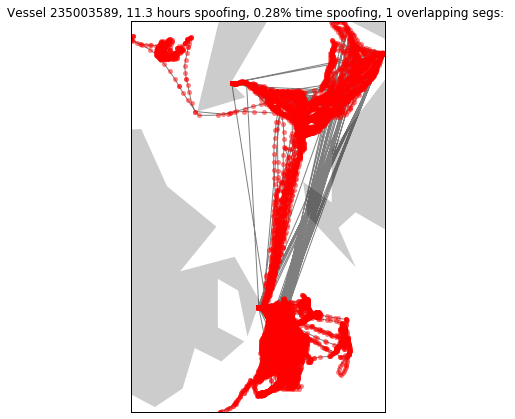

Waiting on bqjob_r24a5792f455dd12f_00000154734553c8_17 ... (14s) Current status: DONE   
Query time: 19.8885960579 seconds.


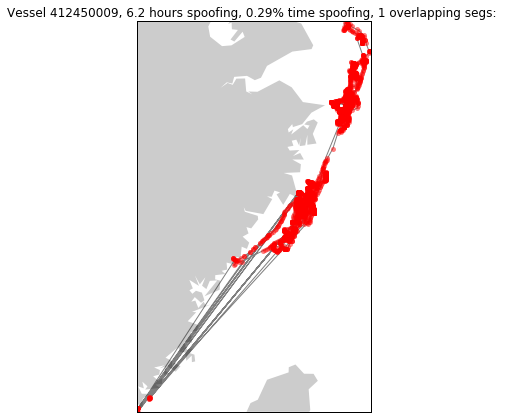

Waiting on bqjob_rbdf1c7a98a4cff_000001547345e83a_18 ... (23s) Current status: DONE   
Query time: 29.4780049324 seconds.


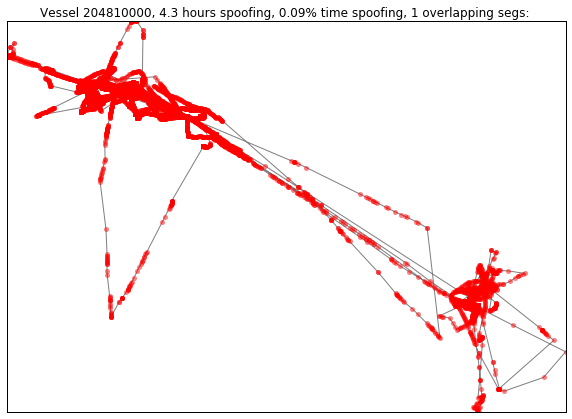

Waiting on bqjob_r405d53fff243ab51_000001547346b07a_19 ... (14s) Current status: DONE   
Query time: 18.7648420334 seconds.


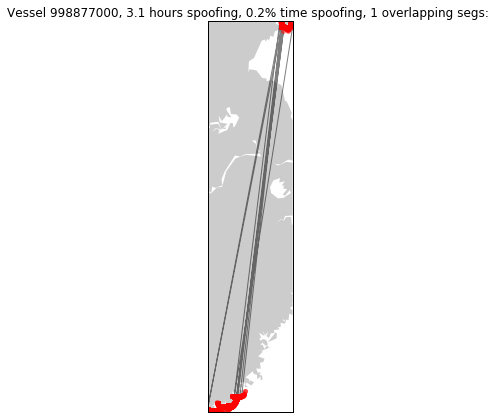

Waiting on bqjob_r3325ab7749b58c56_00000154734740f2_20 ... (14s) Current status: DONE   
Query time: 18.9457352161 seconds.


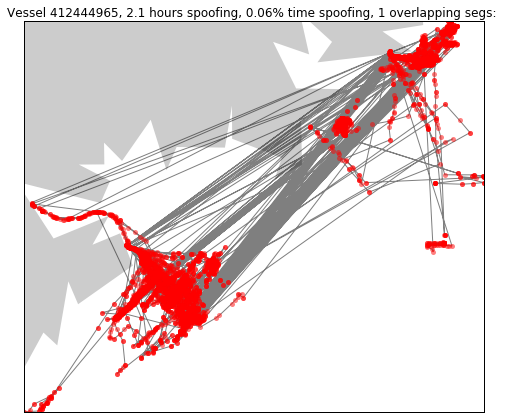

Waiting on bqjob_r1f4103c0ae1618e5_000001547347ddcc_21 ... (14s) Current status: DONE   
Query time: 18.5730450153 seconds.


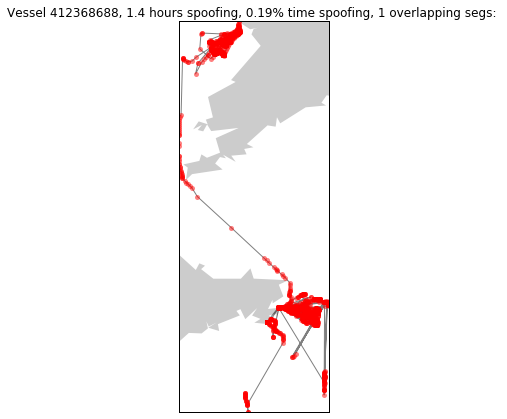

Waiting on bqjob_r154e5bed2383743f_0000015473486933_22 ... (14s) Current status: DONE   
Query time: 18.8396370411 seconds.


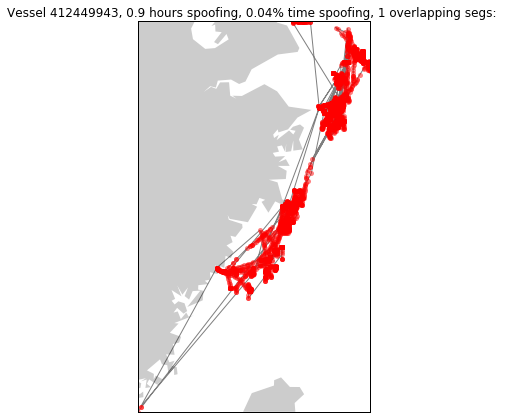

Waiting on bqjob_r7b9626aa6fa6ce51_000001547348fb58_23 ... (23s) Current status: DONE   
Query time: 27.2438559532 seconds.


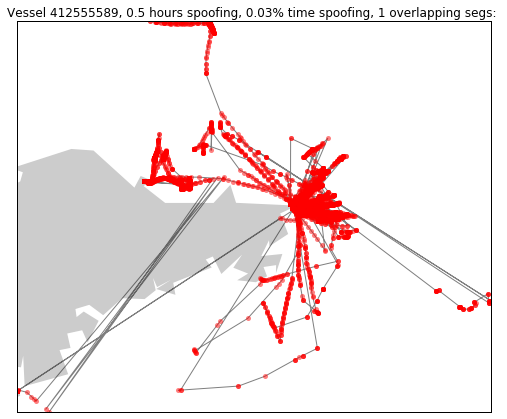

Waiting on bqjob_r6e4500808e804dee_000001547349ac5f_24 ... (14s) Current status: DONE   
Query time: 18.8771650791 seconds.


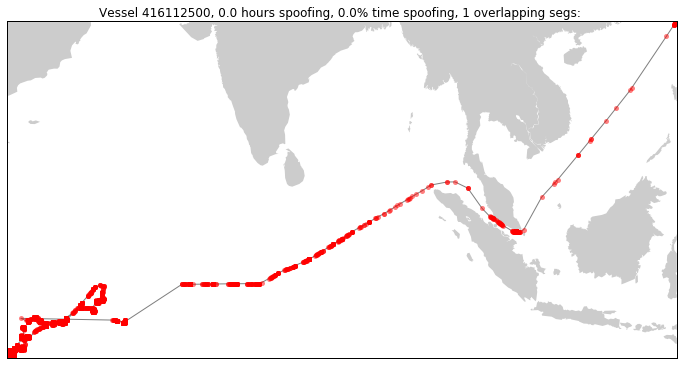

In [21]:
print "mmsi spoofing_hours total_hours spoofing_Percent overlapping_segments"
for i in range(50,len(overlaps),25): # no need to start on the obvious spoofing one
    o = overlaps[i]
    map_mmsi(o[0], "Vessel "+o[0] + ", "+o[1]+" hours spoofing, "+o[3]+"% time spoofing, "+o[4]+" overlapping segs: ")
    #print o[0],o[1],o[2],o[3]+"%", o[4] 


In [22]:
import csv
with open('spoofing_hours_2015.csv', 'wb') as f:
    writer = csv.writer(f)
    writer.writerow(["mmsi","spoofing_hours","total_hours","spoofing_percent","overlapping_segments","num_segments"])
    writer.writerows(overlaps)